# 2D Diffusion FEM in Python

This notebook is a Python translation of an Octave-based finite element simulation for 2D diffusion. It generates a structured mesh over the unit square, assembles the FEM stiffness matrix (with a constant source term), applies Dirichlet boundary conditions (u = 0 on the boundary), solves the linear system, and plots the solution.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

## Mesh Generation

We generate a structured grid on the unit square and create a triangular mesh by splitting each square element into two triangles.

In [8]:
# Parameters for a structured grid
nx, ny = 20, 20
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xx, yy = np.meshgrid(x, y)
points = np.column_stack((xx.ravel(), yy.ravel()))

# Generate connectivity for triangles (2 triangles per square element)
triangles = []
for i in range(ny-1):
    for j in range(nx-1):
        p1 = i*nx + j
        p2 = i*nx + (j+1)
        p3 = (i+1)*nx + j
        p4 = (i+1)*nx + (j+1)
        triangles.append([p1, p2, p4])
        triangles.append([p1, p4, p3])
triangles = np.array(triangles)

## Assembly of FEM Matrices

We assemble the stiffness matrix for the diffusion operator. In each triangular element, we compute the local stiffness matrix using the standard FEM formulation and integrate a constant source term (f = 1) over the element.

In [10]:
import numpy as np
from scipy.sparse import coo_matrix


def assemble_stiffness(points, triangles):
    # Extract vertex coordinates for each triangle (triangles: (ntri, 3))
    p1 = points[triangles[:, 0]]
    p2 = points[triangles[:, 1]]
    p3 = points[triangles[:, 2]]

    # Compute the area of each triangle (vectorized)
    areas = 0.5 * np.abs((p2[:, 0] - p1[:, 0]) * (p3[:, 1] - p1[:, 1]) -
                         (p3[:, 0] - p1[:, 0]) * (p2[:, 1] - p1[:, 1]))

    # Compute gradients of the basis functions (vectorized)
    # b_all and c_all have shape (ntri, 3)
    b_all = np.column_stack((p2[:, 1] - p3[:, 1],
                             p3[:, 1] - p1[:, 1],
                             p1[:, 1] - p2[:, 1]))
    c_all = np.column_stack((p3[:, 0] - p2[:, 0],
                             p1[:, 0] - p3[:, 0],
                             p2[:, 0] - p1[:, 0]))

    # Lists to collect the global indices and corresponding matrix entries
    row_list = []
    col_list = []
    data_list = []

    # Loop over local element matrix indices (9 iterations total)
    for i in range(3):
        for j in range(3):
            # For all triangles at once:
            # Compute Ke[i,j] = (b_i*b_j + c_i*c_j) / (4*area)
            vals = (b_all[:, i] * b_all[:, j] + c_all[:, i] * c_all[:, j]) / (4 * areas)
            # Global indices for the contribution:
            row_list.append(triangles[:, i])
            col_list.append(triangles[:, j])
            data_list.append(vals)

    # Concatenate all contributions to form vectors of row indices, column indices, and values.
    rows = np.concatenate(row_list)
    cols = np.concatenate(col_list)
    data = np.concatenate(data_list)

    # Assemble the global stiffness matrix (in COO format, then convert to CSR)
    N = points.shape[0]
    K = coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

    # Assemble the load vector F.
    # For each triangle the load vector contribution is (area/3) for each vertex.
    F = np.bincount(triangles.ravel(), weights=np.repeat(areas / 3, 3), minlength=N)

    return K, F

# Example usage:
# points = np.array([[x1, y1], [x2, y2], ...])
# triangles = np.array([[i1, i2, i3], [j1, j2, j3], ...])
K, F = assemble_stiffness(points, triangles)

## Applying Boundary Conditions

We apply Dirichlet boundary conditions (u = 0) on all edges of the unit square.

In [11]:
# Identify boundary nodes (nodes on the edge of the unit square)
tol = 1e-10
boundary_nodes = np.where((np.abs(points[:,0]) < tol) |
                          (np.abs(points[:,0]-1) < tol) |
                          (np.abs(points[:,1]) < tol) |
                          (np.abs(points[:,1]-1) < tol))[0]

# Apply Dirichlet boundary conditions: u = 0 on the boundary
u = np.zeros(N)
for node in boundary_nodes:
    K[node, :] = 0
    K[node, node] = 1
    F[node] = 0

/dolfinx-env/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


## Solving the System

The linear system `K * u = F` is solved using a sparse solver.

In [12]:
K = csr_matrix(K)
u = spsolve(K, F)

## Plotting the Results

We use a contour plot to visualize the solution `u` over the domain.

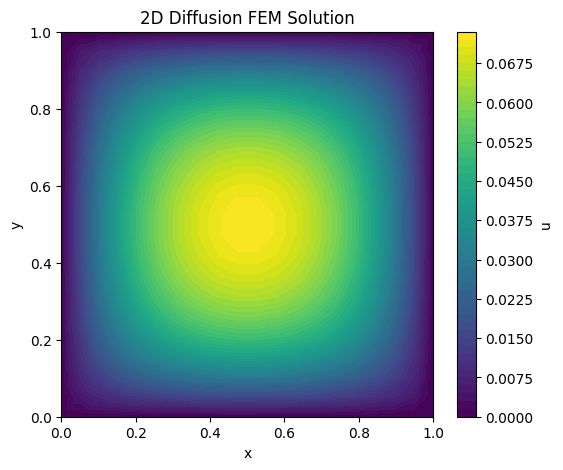

In [13]:
plt.figure(figsize=(6,5))
plt.tricontourf(points[:,0], points[:,1], triangles, u, levels=50, cmap='viridis')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Diffusion FEM Solution')
plt.show()